# GLM-4 analyzes massive amounts of data.

**This tutorial is available in English and is attached below the Chinese explanation**

在此代码中，我使用 GLM 的 Function Call 和 代码能力 对[人口城乡居民比例](urban-rural-population.csv) 进行简单的数据分析工作。你将能体验到

1. 模型是如何对一个csv文件进行读取和数据分析。
2. 模型和工具的交互方式以及模型不断改进的过程。

In this code, I use GLM's Function Call and code capabilities to perform simple data analysis on [Population Urban-Rural Resident Ratio](urban-rural-population.csv). you will be able to experience

1. How the model reads and analyzes data from a csv file.
2. How models and tools interact and the process of continuous model improvement.




In [1]:
import os
from zhipuai import ZhipuAI
import json

os.environ["ZHIPUAI_API_KEY"] = "your api key"
client = ZhipuAI()

设置好执行工具的函数，其中

1. 工具 `execute_cleaned_code_from_string` 代码是为了将模型输出的 Python 代码执行。
2. 工具 `extract_function_and_execute` 将模型的输出拆解并获得执行的代码。

Set up the function to execute the tool, where
1. The tool `execute_cleaned_code_from_string` code is to execute the Python code output by the model.
2. The tool `extract_function_and_execute` disassembles the output of the model and obtains the executed code.



In [4]:
%matplotlib inline

def execute_cleaned_code_from_string(code_string: str = ""):
    import io
    from contextlib import redirect_stdout

    output_buffer = io.StringIO()
    try:
        code_object = compile(code_string, '<string>', 'exec')
        with redirect_stdout(output_buffer):
            exec(code_object)
        return output_buffer.getvalue() if output_buffer.getvalue() else "Code finished successfully!"
    except Exception as e:
        error = "traceback: An error occurred: " + str(e)
        print(error)
        return error


def extract_function_and_execute(llm_output, messages):
    name = llm_output.choices[0].message.tool_calls[0].function.name
    params = json.loads(llm_output.choices[0].message.tool_calls[0].function.arguments)
    tool_call_id = llm_output.choices[0].message.tool_calls[0].id
    function_to_call = globals().get(name)
    if not function_to_call:
        raise ValueError(f"Function '{name}' not found")
    messages.append(
        {
            "role": "tool",
            "content": str(function_to_call(**params)),
            "tool_call_id": tool_call_id
        }
    )
    return messages


tools = [
    {
        "type": "function",
        "function": {
            "name": "execute_cleaned_code_from_string",
            "description": "python code execution tool",
            "parameters": {
                "type": "object",
                "properties": {
                    "code_string": {
                        "type": "string",
                        "description": "Python executable code",
                    },
                },
                "required": ["code_string"],
            },
        }
    }
]

设置一个 系统提示词，作为模型的预定设置并提供已知信息，这样模型能更好的执行我们的指令。

Set a system prompt word as a predetermined setting for the model and provide known information so that the model can better execute our instructions.

In [5]:
sys_prompt = """
You are a data analyst, you will have a code execution tool, you need to write a python script, the tool will execute your content and return the results, now please analyze my csv file.
I will provide you with some information about the csv, which is as follows:
{
     info: Changes in the urban-rural population ratio in major regions of the world from 1500 to 2050. The csv contains five columns, namely
     column info: Entity,Code,Year, Urban population (%) long-run with 2050 projections (OWID),Rural population (%) long-run with 2050 projections (OWID)
     path : 'data/urban-rural-population.csv'
}
Each column has some data, which you need to read through python code.
Now, please follow my requirements, write the code appropriately, and analyze my csv file.
I will provide you with the code to execute the tool, you just need to write the code according to my requirements.
All answers must be provided after querying the csv I provided. Your return must be executable python code and no other content.
Thinking step by step, here's my request, let's get started:
"""

先做一个简单的尝试，在这里，我们绘制50年来美国城乡居民的比例的变化情况。

First, make a simple attempt. Here, we plot the changes in the proportion of urban and rural residents in the United States over the past 50 years.

In [6]:
question = "Read csv and draw the distribution of urban and rural population development in the United States"
messages = [
    {
        "role": "system",
        "content": sys_prompt
    },
    {
        "role": "user",
        "content": question
    }
]
response = client.chat.completions.create(
    model='glm-4',
    messages=messages,
    tools=tools,
    top_p=0.1,
    temperature=0.1,
    max_tokens=2000,
)
response

Completion(model='glm-4', created=1707206981, choices=[CompletionChoice(index=0, finish_reason='tool_calls', message=CompletionMessage(content=None, role='assistant', tool_calls=[CompletionMessageToolCall(id='call_8367733565668098891', function=Function(arguments='{"code_string":"import pandas as pd\\nimport matplotlib.pyplot as plt\\n\\n# 读取CSV文件\\ncsv_path = \\"data/urban-rural-population.csv\\"\\ndata = pd.read_csv(csv_path)\\n\\n# 筛选美国的数据\\nus_data = data[data[\\"Entity\\"] == \\"United States\\"]\\n\\n# 提取年和人口比例数据\\nyears = us_data[\\"Year\\"].tolist()\\nurban_populations = us_data[\\"Urban population (%) long-run with 2050 projections (OWID)\\"].tolist()\\nrural_populations = us_data[\\"Rural population (%) long-run with 2050 projections (OWID)\\"].tolist()\\n\\n# 绘制图表\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, urban_populations, label=\\"Urban\\")\\nplt.plot(years, rural_populations, label=\\"Rural\\")\\nplt.title(\\"Urban and Rural Population Development in the United Stat

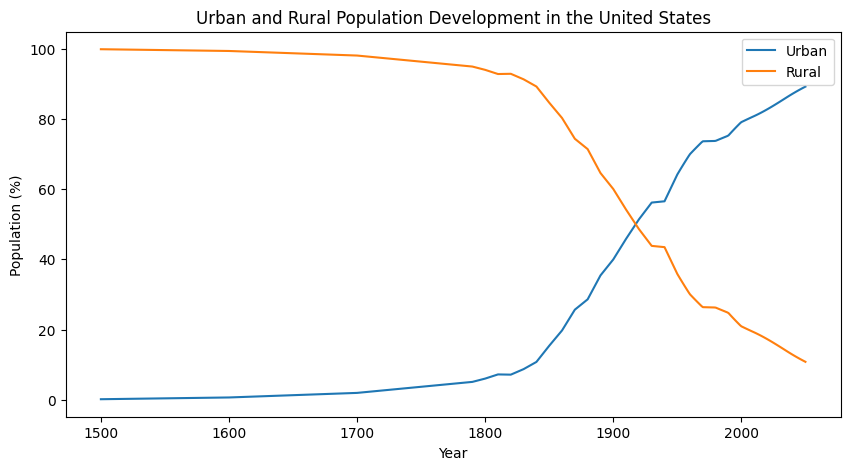

[{'role': 'system',
  'content': "\nYou are a data analyst, you will have a code execution tool, you need to write a python script, the tool will execute your content and return the results, now please analyze my csv file.\nI will provide you with some information about the csv, which is as follows:\n{\n     info: Changes in the urban-rural population ratio in major regions of the world from 1500 to 2050. The csv contains five columns, namely\n     column info: Entity,Code,Year, Urban population (%) long-run with 2050 projections (OWID),Rural population (%) long-run with 2050 projections (OWID)\n     path : 'data/urban-rural-population.csv'\n}\nEach column has some data, which you need to read through python code.\nNow, please follow my requirements, write the code appropriately, and analyze my csv file.\nI will provide you with the code to execute the tool, you just need to write the code according to my requirements.\nAll answers must be provided after querying the csv I provided. Yo

In [7]:
extract_function_and_execute(llm_output=response, messages=messages)

## Continuously call the tool until the data analysis task is completed

由于并不是所有的任务都能通过一次调用工具完成任务，因此，我们需要完善这个代码，使得其能够在调用模型工具的时候获得反馈，如果代码无法执行，模型将获得报错的信息，并重写代码，通过不断的优化，完成最终的任务。在这里，我们完善代码，使其完成一个更复杂的任务，通过不管尝试，验证模型是否能完成任务。

Since not all tasks can be completed by calling the tool once, we need to improve this code so that it can get feedback when calling the model tool. If the code cannot be executed, the model will get error information and rewrite it. The code, through continuous optimization, completes the final task. Here, we refine the code to perform a more complex task and verify that the model can complete the task regardless of attempts.

Question: From 1972 to 2048, did more people in Russia live in cities or in rural areas? What is the rate of growth or decline, and when is the fastest growth or decline?
Try 1 times

Final answer for question: From 1972 to 2048, did more people in Russia live in cities or in rural areas? What is the rate of growth or decline, and when is the fastest growth or decline?
Based on the analysis of the CSV file provided, from 1972 to 2048, the urban population in Russia grew at a faster rate than the rural population. The rate of growth or decline in the population difference between cities and rural areas is approximately 1.97% per year. The fastest growth or decline was observed in the year 1994.
Question: Please draw the distribution of urban and rural population proportions in 2023 and 2030 for all the countries in the table, and summarize the trends.


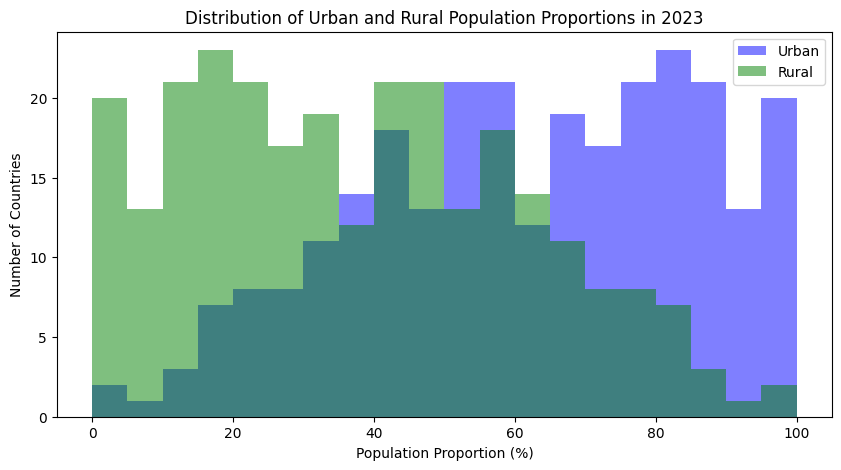

Try 1 times


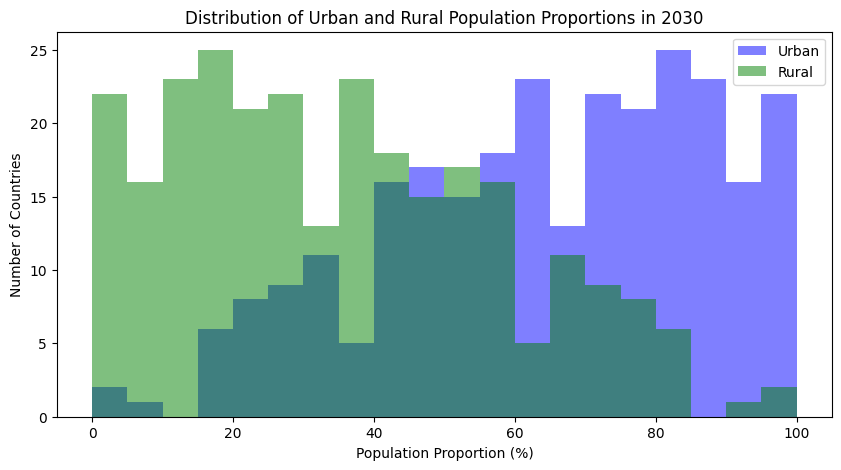

Final answer for question: Please draw the distribution of urban and rural population proportions in 2023 and 2030 for all the countries in the table, and summarize the trends.
Based on the analysis of the urban-rural population csv file, the distribution of urban and rural population proportions in 2023 and 2030 has been visualized using histograms. The trends observed indicate that, on average, the urban population proportion has increased by 2.29% between 2023 and 2030, while the rural population proportion has correspondingly decreased by -2.29%. This suggests a continuing shift from rural to urban living patterns globally.
Question: Compare the average growth rate of urbanized population in 'Colombia,Luxembourg and Macao' and draw a bar chart to tell me which country has the fastest growing proportion of urban population
Try 1 times


traceback: An error occurred: unexpected character after line continuation character (<string>, line 25)


<string>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


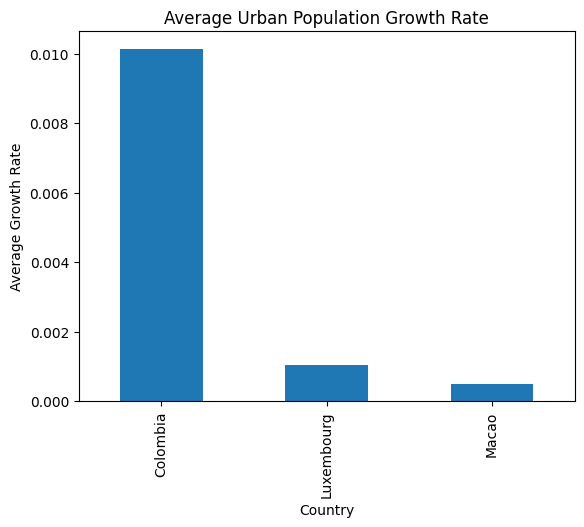

Try 2 times

Final answer for question: Compare the average growth rate of urbanized population in 'Colombia,Luxembourg and Macao' and draw a bar chart to tell me which country has the fastest growing proportion of urban population
The executable Python code has been executed successfully. The bar chart showing the average growth rate of the urbanized population in Colombia, Luxembourg, and Macao has been displayed. The country with the fastest growing proportion of urban population can be determined by analyzing the bar chart.


In [8]:
questions = [
    "From 1972 to 2048, did more people in Russia live in cities or in rural areas? What is the rate of growth or decline, and when is the fastest growth or decline?",
    "Please draw the distribution of urban and rural population proportions in 2023 and 2030 for all the countries in the table, and summarize the trends.",
    "Compare the average growth rate of urbanized population in 'Colombia,Luxembourg and Macao' and draw a bar chart to tell me which country has the fastest growing proportion of urban population"
]

for question in questions:
    print("====================================================")
    print("Question:", question)
    messages = [
        {
            "role": "system",
            "content": sys_prompt
        },
        {
            "role": "user",
            "content": question
        }
    ]

    number_try = 0
    while True:
        response = client.chat.completions.create(
            model='glm-4',
            messages=messages,
            top_p=0.1,
            tools=tools,
            temperature=0.1,
            max_tokens=2000,
        )

        if response.choices[0].finish_reason == "stop":
            print("Final answer for question:", question)
            print(response.choices[0].message.content)
            break
        elif response.choices[0].finish_reason == "tool_calls":
            number_try += 1
            if number_try > 10:
                print("Too many attempts, automatic stop for question:", question)
                break
            else:
                print(f"Try {number_try} times")
                print("====================================================\n\n")

            messages.append(
                {
                    "role": response.choices[0].message.role,
                    "tool_calls": [
                        {
                            "id": response.choices[0].message.tool_calls[0].id,
                            "type": "function",
                            "index": 0,
                            "function": {
                                "arguments": response.choices[0].message.tool_calls[0].function.arguments,
                                "name": response.choices[0].message.tool_calls[0].function.name
                            }
                        }
                    ]

                }
            )
            extract_function_and_execute(llm_output=response, messages=messages)


## Conclusion
模型能在一定程度上完成简单的数据分析任务，虽然完成复杂任务具有一定的困难，但是通过多次尝试，也能获得满意的结果。
你可以在更多的场合中使用GLM-4模型对数据分析工作进行深度的探索。

The model can complete simple data analysis tasks to a certain extent. Although it is difficult to complete complex tasks, satisfactory results can be obtained through multiple attempts.
You can use the GLM-4 model on more occasions to conduct in-depth exploration of data analysis work.